In [229]:
import numpy as np
import scipy.sparse as ss
import random
import pandas as pd

from corextopic import corextopic as ct
from corextopic import vis_topic as vt # jupyter notebooks will complain matplotlib is being loaded twice

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

import gensim
from sklearn.datasets import fetch_20newsgroups
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary

import os
import numpy as np
import pandas as pd
import pickle
import pyLDAvis
import pyLDAvis.gensim_models


from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [233]:
import matplotlib.pyplot as plt
def describe_training_documents(list_of_docs):
    print('There are',len(list_of_docs),'documents.')
    document_lengths = list(map(lambda x: len(x.split()),list_of_docs))
    percentile_50 = int(np.percentile(document_lengths,50))
    percentile_95 = int(np.percentile(document_lengths,95))
    print('95% of the documents are below:',percentile_95,'words.')
    plt.axvline(percentile_50, lw=1, color='g')
    plt.axvline(percentile_95, lw=1, color='r', linestyle='--')
    _ = plt.hist(document_lengths, bins=50, range=(0,percentile_95+100))
    print('Solid green line indicates median, dotted red line indicates 95 percentile. Outliers may be cropped.')

def flatten_list(l):
    return [item for sublist in l for item in sublist]

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

def chop(text):
    temp=text.split()
    num=len(temp)//30
    new=[]
    for i in range(num):
        if i !=num-1:
            a=temp[30*i:30*(i+1)]
        else:
            a=temp[30*(num-1):]
        new.append(" ".join(a))
    return new

In [234]:
# Get 20 newsgroups data
newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
documents_train = list(np.load('./training/train.npy')) # historical materials 4451 documents
documents_train2 = list(np.load('./training/train2.npy'))   # census bureau 4226 documents
df_occsc = pd.read_csv('OCC_pairs.csv').rename(columns={'OCC_DES':'Full Occupation'})
assert(df_occsc['Full Occupation'].nunique() == len(df_occsc))
occ_list = list(set(list(df_occsc['Full Occupation'])))

occ_list2=[]
#eliminate confusing words in the occ_list
confusing_words=['occupation','occupations','Occupations','men']
for occ in occ_list:
    a=occ.split(' ')
    for word in confusing_words:
        if word in a:
            a.remove(word)
    occ_list2.append(' '.join(a))
occ_list=occ_list2    

In [235]:
with open("nyt_text_modified.txt",'r') as f:
    nyt_text2=[]
    lines=f.readlines()
    for line in lines:
        nyt_text2.append(line)

There are 10372 documents.
95% of the documents are below: 605 words.
Solid green line indicates median, dotted red line indicates 95 percentile. Outliers may be cropped.


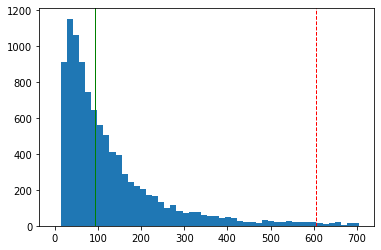

In [236]:
twenty_news=[]
for news in newsgroups.data:
    if len(news.split())>15:
        twenty_news.append(news)
describe_training_documents(twenty_news)
random.seed(10)
twenty_news=random.sample(twenty_news,4000)

In [237]:
# but fit the model with the training dataset
# corex model requires them to be the same shape 
documents = []
documents.extend(documents_train)
documents.extend(documents_train2)
documents.extend(nyt_text2)

documents_mod=[]
for doc in documents:
    chopped=chop(doc)
    for a in chopped:
        tokens=simple_preprocess(a)
        new_tokens=[]
        for word in tokens:
            if not word.isdigit():
                new_tokens.append(word)
        new=" ".join(new_tokens)
        documents_mod.append(new)

In [238]:
document_total=documents_mod[:]
document_total.extend(occ_list)
print(len(documents_mod))
print("In the dataset there are", len(document_total), "textual documents")
print("And this is the first one:\n", documents_mod[0])

20185
In the dataset there are 20621 textual documents
And this is the first one:
 skip to main content search upload sign up log in books video audio software imagesabout blog projects help donate contact jobs volunteer people search metadata search text contents search


## Transform data into a sparse matrix¶

In [239]:
vectorizer = CountVectorizer(stop_words='english', max_features=20000, binary=True)
doc_word = vectorizer.fit_transform(document_total)
doc_word = ss.csr_matrix(doc_word)
fixed_vocabulary=vectorizer.vocabulary_
words = list(np.asarray(vectorizer.get_feature_names()))

In [240]:
topic_num=60
topic_model = ct.Corex(n_hidden=topic_num, words=words, eps=1e-2,max_iter=100, verbose=False, seed=1)
topic_model.fit(doc_word[:len(documents_mod)], words=words)

In [241]:
# Print a single topic from CorEx topic model
topic_model.get_topics(topic=20, n_words=10)

[('iron', 0.022220762512060243, 1.0),
 ('avoid', 0.01701832503145899, 1.0),
 ('oil', 0.014392377507319436, 1.0),
 ('acid', 0.013889034891950749, 1.0),
 ('rosin', 0.011602123444247244, 1.0),
 ('turpentine', 0.011254591700622716, 1.0),
 ('disclosure', 0.010994597980784147, 1.0),
 ('sulphuric', 0.01075330645106408, 1.0),
 ('pig', 0.009303102241339001, 1.0),
 ('acids', 0.009044269061601006, 1.0)]

In [242]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: products,value,total,establishments,cent,reported,industry,manufacture,statistics,materials
1: water,mold,surface,add,dry,glue,inch,cement,cut,hot
2: wage,earners,number,employed,average,according,prevailing,classified,classification,employees
3: fig,pieces,sides,piece,legs,inches,ends,chairs,seat,style
4: president,committee,national,association,meeting,institute,announced,annual,technology,held
5: proportion,gainful,south,occupations,north,divisions,gainfully,central,carolina,ohio
6: yesterday,today,american,john,avenue,dr,company,mrs,afternoon,charles
7: furniture,carved,cabinet,maker,examples,inlaid,ivory,articles,ebony,egyptian
8: banks,precinct,debits,aggregated,transfers,accounts,assignments,patrolmen,san,century
9: art,exhibition,museum,paintings,galleries,gallery,ornament,artists,sculpture,exhibitions
10: university,mr,night,house,college,examination,cambridge,universities,pres,govt
11: police,judge,sign,heard,jury,murder,detective,minus,denotes,talent
12: union,local,inter

In [244]:
results=topic_model.predict(doc_word[len(documents_mod):])
results.shape

(436, 60)

## Total Corelation and Model Selection

In [245]:
topic_model.tc 

7.694873697953975

In [246]:
topic_model.tcs.shape

(60,)

In [247]:
print(np.sum(topic_model.tcs))
print(topic_model.tc)

7.694873697953975
7.694873697953975


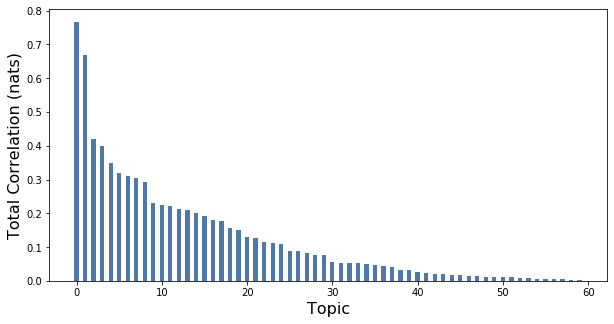

In [248]:
#Selecting number of topics:Choosing from the data visualised
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);
plt.savefig('Distribution of TCs for each topic', dpi=600)

## Pointwise Document TC

In [249]:
topic_model.log_z.shape # n_docs x k_topics

(20185, 60)

In [250]:
print(np.mean(topic_model.log_z, axis=0)) #The pointwise total correlations in log_z represent the correlations within an individual document explained by a particular topic. These correlations have been used to measure how "surprising" documents are with respect to given topics
print(topic_model.tcs)

[0.7666987  0.66968749 0.41855172 0.40066464 0.34764331 0.31964527
 0.31095927 0.30449393 0.29347215 0.23020479 0.22493407 0.22296618
 0.21302086 0.20966109 0.20215531 0.19126375 0.18053641 0.17605639
 0.15678979 0.15066821 0.13020851 0.12630818 0.11463038 0.11225031
 0.1083821  0.08804833 0.08735038 0.08257416 0.07757646 0.07518914
 0.05602369 0.05384632 0.0521632  0.05188291 0.04933444 0.04782114
 0.04321232 0.04094134 0.03332723 0.0315001  0.02637425 0.02297206
 0.02007195 0.01943375 0.01768806 0.01595645 0.01466941 0.01284625
 0.01208578 0.01204638 0.01138416 0.00984297 0.00942613 0.00692308
 0.0067517  0.00577819 0.0056063  0.00507438 0.00378875 0.00350973]
[0.7666987  0.66968749 0.41855172 0.40066464 0.34764331 0.31964527
 0.31095927 0.30449393 0.29347215 0.23020479 0.22493407 0.22296618
 0.21302086 0.20966109 0.20215531 0.19126375 0.18053641 0.17605639
 0.15678979 0.15066821 0.13020851 0.12630818 0.11463038 0.11225031
 0.1083821  0.08804833 0.08735038 0.08257416 0.07757646 0.075

## Introducing Anchoring in the semi-supervised topic mode

CorEx is a discriminative model, whereas LDA is a generative model. This means that while LDA outputs a probability distribution over each document, CorEx instead estimates the probability a document belongs to a topic given that document's words. As a result, the probabilities across topics for a given document do not have to add up to 1. The estimated probabilities of topics for each document can be accessed through log_p_y_given_x or p_y_given_x.

Hierarchical Topic Models The labels attribute gives the binary topic expressions for each document and each topic. We can use this output as input to another CorEx topic model to get latent representations of the topics themselves. This yields a hierarchical CorEx topic model. Like the first layer of the topic model, one can determine the number of latent variables to add in higher layers through examination of the topic TCs.

Anchored CorEx is an extension of CorEx that allows the "anchoring" of words to topics. When anchoring a word to a topic, CorEx is trying to maximize the mutual information between that word and the anchored topic. So, anchoring provides a way to guide the topic model towards specific subsets of words that the user would like to explore.

Anchoring a single set of words to a single topic. This can help promote a topic that did not naturally emerge when running an unsupervised instance of the CorEx topic model. For example, one might anchor words like "snow," "cold," and "avalanche" to a topic if one suspects there should be a snow avalanche topic within a set of disaster relief articles.

Anchoring single sets of words to multiple topics. This can help find different aspects of a topic that may be discussed in several different contexts. For example, one might anchor "protest" to three topics and "riot" to three other topics to understand different framings that arise from tweets about political protests.

Anchoring different sets of words to multiple topics. This can help enforce topic separability if there appear to be chimera topics. For example, one might anchor "mountain," "Bernese," and "dog" to one topic and "mountain," "rocky," and "colorado" to another topic to help separate topics that merge discussion of Bernese Mountain Dogs and the Rocky Mountains.

In [251]:
#to automatically generate anchor words: for each label in a data set, 
#we find the words that have the highest mutual information with the label.
# we took a very simple to automatically generate the anchor words to create a semi-supervised model
anchor_words=[]
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    anchor_words.append(list(topic_words[:3]))
    print('{}: '.format(n) + ','.join(topic_words))

0: products,value,total,establishments,cent,reported,industry,manufacture,statistics,materials
1: water,mold,surface,add,dry,glue,inch,cement,cut,hot
2: wage,earners,number,employed,average,according,prevailing,classified,classification,employees
3: fig,pieces,sides,piece,legs,inches,ends,chairs,seat,style
4: president,committee,national,association,meeting,institute,announced,annual,technology,held
5: proportion,gainful,south,occupations,north,divisions,gainfully,central,carolina,ohio
6: yesterday,today,american,john,avenue,dr,company,mrs,afternoon,charles
7: furniture,carved,cabinet,maker,examples,inlaid,ivory,articles,ebony,egyptian
8: banks,precinct,debits,aggregated,transfers,accounts,assignments,patrolmen,san,century
9: art,exhibition,museum,paintings,galleries,gallery,ornament,artists,sculpture,exhibitions
10: university,mr,night,house,college,examination,cambridge,universities,pres,govt
11: police,judge,sign,heard,jury,murder,detective,minus,denotes,talent
12: union,local,inter

In [255]:
#manually adjust the anchor words based on the observation
    
anchor_words[0]=['manufacturing','mechanical','industry']
anchor_words[1]=['water','mold','cement']
anchor_words[2]=['wage','employed','workers','classified']
anchor_words[3]=['chairs','carpenters']
anchor_words[4]=['government','officials','committee','institute']
anchor_words[5]=['agriculture','farmers','gainful']
anchor_words[7]=['furniture','carve','makers'] 
anchor_words[8]=['bank','bankers','debits','money'] 
anchor_words[9]=['art','gallery','artists','gallery']
anchor_words[10]=['university','college','professional']
anchor_words[11]=['police','judges','detectives']
anchor_words[12]=['trades','delegates','executive']
anchor_words[16]=['cooks','food','serve']
anchor_words[21]=['car','tire','electric','power']
anchor_words[25]=['animal','forestry','husbandry']
anchor_words[29]=['commercial','business']
anchor_words[30]=['court','lawyers','officials','justice']
anchor_words[31]=['home','domestic','servants']
anchor_words[32]=['book','authors','publishing']
anchor_words[32]=['market','sales','store']
anchor_words[39]=['machinery','steel','operations','operatives']
anchor_words[51]=['population']

In [252]:
def train_model(topic_num,anchor_w=anchor_words):
    anchored_topic_model= ct.Corex(n_hidden=topic_num, seed=2)
    anchored_topic_model.fit(doc_word[:len(documents_mod)], words=words, anchors=anchor_w, anchor_strength=10)
    print("-"*12,"topic words","-"*12)
    for n in range(topic_num):
        topic_words,_,_ = zip(*anchored_topic_model.get_topics(topic=n))
        print('{}: '.format(n) + ','.join(topic_words))
    print("-"*12,"print total correlation","-"*12)
    print(np.sum(anchored_topic_model.tcs))
    print(anchored_topic_model.tc)
    results=anchored_topic_model.predict(doc_word[len(documents_mod):])
    results_proba,mutual_info=anchored_topic_model.predict_proba(doc_word[len(documents_mod):])
    
    pairs=get_predict_result(results)
    pairs_proba=get_predict_proba(results_proba)
    
    has_categorized=[]
    for a,b in pairs:
        if a not in has_categorized:
            has_categorized.append(a)
    print("-"*12,"occ that have been categorized into certain types","-"*12)
    print(len(has_categorized))

    has_not_categorized=[]
    for i in range(len(occ_list)):
        if i not in has_categorized:
            has_not_categorized.append(occ_list[i])
          
    print("-"*12,"has_not_categorized","-"*12)
    print(has_not_categorized)

    print("-"*12,"corresponding counts of topic","-"*12)
    print(count_topics(pairs))
    
    return anchored_topic_model,pairs,pairs_proba

In [253]:
def get_predict_result(results):
    pairs=[]
    for i in range(len(results)):
        for j in range(len(results[i])):
            if results[i][j]==True:
                pairs.append([i,j])
    return pairs

probability_threshold=1e-3

def get_predict_proba(results_proba):
    pairs_proba={i:[] for i in range(len(results_proba))}
    for i in range(len(results_proba)):
        for j in range(len(results_proba[i])):
            if results_proba[i][j] >= probability_threshold:
                pairs_proba[i].append((j,results_proba[i][j]))
    return pairs_proba

def count_topics(pairs):
    available={}
    for a,b in pairs:
        if b not in available.keys():
            available[b]=1
        else:
            available[b]+=1
    return available 

def get_topic_content(pairs,topic):
    result=[]
    for a,b in pairs:
        if b == topic:
            result.append(occ_list[a])
    return result 

def get_topic_list(pairs):
    result={}
    for a,b in pairs:
        if b not in result.keys():
            result[b]=[a]
        else:
            result[b].append(a)
    return result

def save_topic(pairs):
    result_dic=get_topic_list(pairs)
    with open("train_result_30.txt",'w') as f:
        for m,n in result_dic.items():
            topic_words,_,_ = zip(*anchored_topic_model.get_topics(topic=m))
            title=str(m)+":"+(','.join(topic_words))
            f.write(title+'\n')
            for file in n:
                occ_title=occ_list[file]
                f.write(occ_title+'\n')
            f.write("\n \n \n")

In [256]:
anchored_topic_model,pairs,pairs_proba =train_model(60,anchor_words)
anchored_topic_model.save('saved.dat')

------------ topic words ------------
0: industry,manufacturing,mechanical,branches,summary,presents,growth,shipbuilding,chemical,development
1: water,mold,cement,add,boil,dry,hot,mix,till,mixture
2: wage,workers,employed,classified,earners,number,average,according,classification,employment
3: chairs,fig,inch,cut,sides,piece,inches,legs,ends,pieces
4: committee,government,institute,officials,technology,phipps,intercollegiate,securities,millikan,investigating
5: gainful,agriculture,farmers,occupations,porto,rico,divisions,hawaii,agricultural,farm
6: yesterday,american,today,ap,hospital,luncheon,shipment,lake,admiral,waldorf
7: furniture,makers,style,decoration,cabinet,ebony,marquetry,ivory,decorated,renaissance
8: money,debits,bank,bankers,banks,aggregated,accounts,cities,preceding,ending
9: art,gallery,artists,exhibition,paintings,museum,galleries,sculpture,exhibitions,arts
10: university,college,professional,law,universities,examination,ussr,cambridge,govt,com
11: police,president,jud

In [257]:
df_occsc = pd.read_csv('OCC_pairs.csv').rename(columns={'OCC_DES':'Full Occupation'})
assert(df_occsc['Full Occupation'].nunique() == len(df_occsc))
occ_original = list(set(list(df_occsc['Full Occupation'])))

In [258]:
topic_score_dict = {} # key: topic, value: occscore
topic_helper={i:[] for i in range(topic_num)}
for job_num in pairs_proba.keys():
    topic_prob=pairs_proba[job_num]
    s=0
    for pair in topic_prob:
        occ=occ_original[job_num]
        score = list(df_occsc[df_occsc['Full Occupation']==occ]['OCCSCORE'])[0]
        weight = pair[1]
        s += weight
        topic_helper[pair[0]].append((score,weight))

for topic in topic_helper.keys():
    lst = topic_helper[topic]
    score_list=[]
    s=0
    for pair in lst:
        occ_score = 0
        s += pair[1]
    occ_score = 0
    for pair in lst:
        occ_score += pair[0] * (pair[1]/s)
    topic_score_dict[topic] = occ_score

In [259]:
topic_score_dict

{0: 24.535135135135086,
 1: 28.071428571428562,
 2: 26.757658909755005,
 3: 24.64360480100852,
 4: 37.478044567070434,
 5: 12.927498320146725,
 6: 42.0,
 7: 24.733132767546476,
 8: 34.70857164694976,
 9: 34.89498006892315,
 10: 32.51953819715098,
 11: 29.291195066331248,
 12: 21.337773265685875,
 13: 21.997534744731126,
 14: 40.0,
 15: 0,
 16: 22.030546705261326,
 17: 24.224846256417745,
 18: 33.544099736504414,
 19: 28.759672779024047,
 20: 25.802628001944214,
 21: 23.404772848376552,
 22: 0,
 23: 0,
 24: 30.199999999999996,
 25: 18.774636498374125,
 26: 31.860877556319938,
 27: 35.01986102915557,
 28: 29.0,
 29: 32.996907683039126,
 30: 35.373601549337906,
 31: 18.837837837837835,
 32: 32.88383473597346,
 33: 26.70588235294117,
 34: 24.0,
 35: 0,
 36: 15.0,
 37: 29.884363789950353,
 38: 0,
 39: 22.93435135924735,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 42.00000009207575,
 48: 27.0,
 49: 21.5,
 50: 0,
 51: 0,
 52: 23.953566839330453,
 53: 0,
 54: 0,
 55: 16.350662

## Load modified occ description

### Load Ancestry census data and calculate occ score¶

In [261]:
file = open('common_occupation_correction.pkl','rb')
mapping = pickle.load(file)
def mod_occ(occ):
    if occ in mapping.keys():
        return mapping[occ]
    else:
        return occ

df_ward = pd.read_csv('1910_New York_Manhattan Ward 9.csv')
df_ward['Occupation'] = df_ward['Occupation'].apply(lambda x : mod_occ(x))
df_ward['Full Occupation'] = df_ward['Industry'] + ' ' + df_ward['Occupation']

In [262]:
# 32771 full occupations are nan values
print(df_ward['Full Occupation'].isna().sum())

32771


### Compute occupation score of the given occupations¶

In [269]:
def plural(word):
    if word.endswith('y'):
        return word[:-1] + 'ies'
    elif word[-1] in 'sx' or word[-2:] in ['sh', 'ch']:
        return word + 'es'
    elif word.endswith('an'):
        return word[:-2] + 'en'
    else:
        return word + 's'
    
#debug
nan_count=topics_emp=0
not_in_dict_topicId=[]
empty_score=0
empty_score_occ_list=[]
not_in_dict_occ_with_dup=[]
#-------

def match_occ(occ):
    global nan_count
    global not_in_dict_topicId
    global empty_score
    global empty_score_occ_list
    global not_in_dict_occ_with_dup
    #-------
    if type(occ) == float:
        
        #debug
        nan_count+=1
        #-------
        
        return 0
    else:
        shou ji
        temp=[i.lower() for i in occ.split()]
        occ=" ".join(temp)
        doc_word1 = vectorizer.fit_transform([occ])
        doc_word1 = ss.csr_matrix(doc_word1)
        proba, mutual_info =anchored_topic_model.predict_proba(doc_word1)
        pairs=get_predict_proba(proba)
        
        if pairs == {}:
            
            #debug
            topics_emp+=1
            #-------
            return 0
        else:
            score_list = []
            s = 0
            for pair in pairs[0]:
                #print(pairs[0])
                if pair[0] in topic_score_dict.keys():
                    score = topic_score_dict[pair[0]]
                    weight = np.e**pair[1]
                    s += weight
                    score_list.append((score,weight))       
            #debug
                else:
                    if pair[0] not in not_in_dict_topicId:
                        not_in_dict_topicId.append(pair[0])
                    not_in_dict_occ_with_dup.append(occ) 
            if score_list==[]: #when occ's score_list is completely empty (i.e. occ_score must be 0)
                empty_score+=1
                empty_score_occ_list.append(occ)
                
            #-------
            occ_score = 0
            for pair in score_list:
                occ_score += pair[0] * (pair[1]/s)
                
            return occ_score


In [270]:
df_ward['Occupation Score'] = df_ward['Full Occupation'].apply(lambda x : match_occ(x))

In [271]:
df_ward['Occupation Score'] =  df_ward['Occupation Score'].apply(lambda x:  round(x, 5))
df_ward

,DataID,RecordId,Name,HouseHoldId,Street Name,House Number,Dwelling Number,Family Number,Surname,Relationship,...,Can Read,Can Write,Attended School,Own or Rent,Home owned,Farm or House,Survivor of Confederate or Union of Army or Navy,Blind,Full Occupation,Occupation Score
0,31776_4449715-00931,18527185,Mamie Rodgers,18527185,Barrow St,51,4,24.0,Rodgers,Wife,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
1,31776_4449715-00931,18527188,William K Micheals,18527188,Barrow St,49,5,25.0,Micheals,Head,...,Yes,Yes,NaN,Own,Mortgaged,House,NaN,NaN,Storage Worker Lawyer,26.62683
2,31776_4449715-00931,125203061,Elizabeth Micheals,18527188,Barrow St,49,5,25.0,Micheals,Wife,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
3,31776_4449715-00931,125203062,Stewart Micheals,18527188,Barrow St,49,5,25.0,Micheals,Son,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,City Waiter Worker Water Inspector,29.60742
4,31776_4449715-00931,125203063,William Micheals Jr.,18527188,Barrow St,49,5,25.0,Micheals Jr.,Son,...,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64790,4449600_01218,106472699,James H Ritlaw,18553238,Little West 12 St,8,60.0,234.0,Ritlaw,Son,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
64791,4449600_01218,106472700,Mary B Ritlaw,18553238,Little West 12 St,8,60.0,234.0,Ritlaw,Daughter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
64792,4449600_01219,18553247,Ammar Mayne,18553247,St 14th St,452,61.0,235.0,Mayne,Head,...,Yes,Yes,NaN,Rent,NaN,House,NaN,NaN,NaN,0.00000
64793,4449600_01219,18553246,John J Dwyer,18553247,St 14th St,452,61.0,235.0,Dwyer,Boarder,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,Liquors Clerk,23.95357


In [276]:
print(len(empty_score_occ_list))

495


Text(0.5, 1.0, 'new: subset=all')

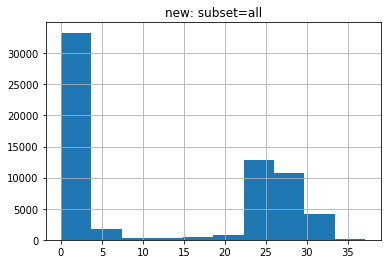

In [273]:
df_ward['Occupation Score'].hist()
plt.title("new: subset=all")

Text(0.5, 1.0, 'old: subset=test,without 0 scores')

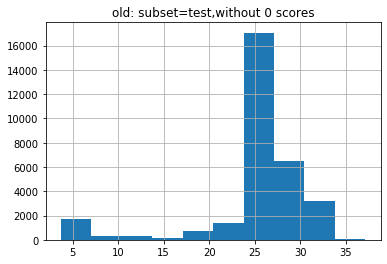

In [274]:
#plot histogram without the 0 values:
selection=(df_ward['Occupation Score']!=0)
df_ward[selection]['Occupation Score'].hist()
plt.title("old: subset=test,without 0 scores")

## Train Word2Vec model 

In [281]:
def generate_labels(label):
    labels=[]
    for i in range(len(label)):
        no_value=True
        for j in range(topic_num):
            if label[i][j]==True:
                labels.append(j)
                no_value=False
                break
        if no_value:
            labels.append('nothing')
    return labels

labels=generate_labels(anchored_topic_model.labels)
label_for_use=[]
nothing_index=[]
for i in range(len(labels)):
    if labels[i]=='nothing':
        nothing_index.append(i)
    else:
        label_for_use.append(labels[i])

In [282]:
all_words=[]
for s in range(len(document_total)):
    if s not in nothing_index:
        temp=tokenize(document_total[s])
        all_words.append(temp)

In [283]:
import time
from gensim.models import Word2Vec
startTime = time.time()
word2vec_model = Word2Vec(all_words[:len(label_for_use)], size=200, iter=10, min_count=20)
usedTime = time.time() - startTime
print('形成word2vec模型共花费%.2f秒' %usedTime)

形成word2vec模型共花费3.14秒


In [284]:
import warnings
warnings.filterwarnings('ignore')

In [285]:
word2vec_model.wv.most_similar('clerks')

[('proprietors', 0.9293720722198486),
 ('officials', 0.9177597165107727),
 ('equal', 0.8990936279296875),
 ('weekly', 0.8790826797485352),
 ('maximum', 0.8758164048194885),
 ('earnings', 0.8735213875770569),
 ('female', 0.8708840608596802),
 ('spinners', 0.8699986934661865),
 ('seasonal', 0.8694870471954346),
 ('minimum', 0.866730809211731)]

In [286]:
word2vec_model.similarity('clerical','clerks')

0.49540165

In [287]:
import numpy as np

def get_contentVector(cutWords, word2vec_model):
    vector_list = [word2vec_model.wv[k] for k in cutWords if k in word2vec_model]
    contentVector = np.array(vector_list).mean(axis=0)
    return contentVector

In [308]:
import time

startTime = time.time()
contentVector_list = []
for i in range(len(all_words[:len(label_for_use)])):
    cutWords = all_words[i]
    content_vector=get_contentVector(cutWords, word2vec_model)
    contentVector_list.append(content_vector)
contentVector_list.pop(5976)
X = np.array(contentVector_list)
X.shape

(19548, 200)

In [309]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
y=label_for_use[:]
y.pop(5976)
y = labelEncoder.fit_transform(y)
print(X.shape, y.shape)

(19548, 200) (19548,)


In [310]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

logisticRegression_model = LogisticRegression()
logisticRegression_model.fit(X,y)

LogisticRegression()

In [311]:
contentVector_predict = []
for i in range(len(all_words[len(label_for_use):])):
    cutWords = all_words[len(label_for_use):][i]
    content_vector=get_contentVector(cutWords, word2vec_model)
    contentVector_predict.append(content_vector)
X_predict = np.array(contentVector_predict)
results=logisticRegression_model.predict(X_predict)
word2vec_result=[]
for i in range(len(results)):
    word2vec_result.append([i,results[i]])

In [312]:
predict_same=0
for i in range(len(word2vec_result)):
    word2vec=word2vec_result[i]
    index=word2vec[0]
    for a,b in pairs:
        if a==index:
            if b==word2vec[1]:
                predict_same+=1
            print(occ_list[i],word2vec[1],b)

Manufacturing and Mechanical Industries Semiskilled operatives, food industries Semiskilled operatives, harness and saddle industries 0 0
Manufacturing and Mechanical Industries Semiskilled operatives, food industries Semiskilled operatives, harness and saddle industries 0 16
Manufacturing and Mechanical Industries Semiskilled operatives, food industries Semiskilled operatives, harness and saddle industries 0 26
Manufacturing and Mechanical Industries Semiskilled operatives, food industries Semiskilled operatives, harness and saddle industries 0 39
Extraction of Minerals Operatives in other and not specified mines Quarry operatives 27 39
Professional Service Designers, drafters, and inventors Draftsmen 5 10
Trade Laborers in coal and lumber yards, warehouses, etc. Elevators 27 27
Public Service, Not Elsewhere Classified Officials and inspectors -- state and United States Postmasters 0 2
Public Service, Not Elsewhere Classified Officials and inspectors -- state and United States Postmas

Professional Service Actors and showmen Actors 5 10
Professional Service Actors and showmen Actors 5 18
Trade Retail dealers Ice 27 27
Domestic and Personal Service Laundry owners, officials, and managers Owners and proprietors 10 4
Domestic and Personal Service Laundry owners, officials, and managers Owners and proprietors 10 30
Domestic and Personal Service Laundry owners, officials, and managers Owners and proprietors 10 31
Manufacturing and Mechanical Industries Mechanics, not otherwise specified Gunsmiths, locksmiths, bellhangers 0 0
Transportation Laborers, not otherwise specified Water transportation 1 1
Trade Retail dealers Furniture 7 7
Trade Retail dealers Furniture 7 27
Trade Other pursuits, semi-skilled Other 27 27
Trade Retail dealers Crockery, glassware, and queensware 27 26
Trade Retail dealers Crockery, glassware, and queensware 27 27
Professional Service Attendants and helpers -- professional service Stage hands and circus helpers 5 10
Professional Service Attendants a

In [313]:
topic_score_dict_word2vec = {} # key: topic, value: occscore
topic_helper_word2vec={i:[] for i in range(topic_num)}
for a,b in word2vec_result:
    occ=occ_original[a]
    score = list(df_occsc[df_occsc['Full Occupation']==occ]['OCCSCORE'])[0]
    topic_helper_word2vec[b].append(score)

for topic in topic_helper_word2vec.keys():
    lst = topic_helper_word2vec[topic]
    if len(lst)!=0:
        occ_score=sum(lst)/len(lst)
        topic_score_dict_word2vec[topic] = occ_score
topic_score_dict_word2vec

{0: 25.475728155339805,
 1: 28.0,
 2: 15.0,
 5: 23.285714285714285,
 6: 42.0,
 7: 28.333333333333332,
 10: 30.92,
 11: 28.11627906976744,
 12: 42.0,
 13: 21.5,
 17: 42.0,
 20: 24.0,
 24: 36.0,
 27: 34.2,
 31: 9.0,
 37: 25.0,
 52: 42.0}

In [314]:
import math
def word2vec_predict(occ):
    if type(occ) == float:
        return 0
    temp=tokenize(occ)
    contentVector_list = []
    content_vector=get_contentVector(temp, word2vec_model)
    if type(content_vector)==np.float64:
        return 0
    contentVector_list.append(content_vector)
    X_predict = np.array(contentVector_list)
    result=logisticRegression_model.predict(X_predict)
    if result[0] in topic_score_dict_word2vec.keys():
        occ_score=topic_score_dict_word2vec[result[0]]
        return occ_score
    else:
        return 0

df_ward['Occupation Score_Word2Vec'] = df_ward['Full Occupation'].apply(lambda x : word2vec_predict(x))
df_ward['Occupation Score_Word2Vec'] =  df_ward['Occupation Score_Word2Vec'].apply(lambda x:  round(x, 5))
df_ward

,DataID,RecordId,Name,HouseHoldId,Street Name,House Number,Dwelling Number,Family Number,Surname,Relationship,...,Can Write,Attended School,Own or Rent,Home owned,Farm or House,Survivor of Confederate or Union of Army or Navy,Blind,Full Occupation,Occupation Score,Occupation Score_Word2Vec
0,31776_4449715-00931,18527185,Mamie Rodgers,18527185,Barrow St,51,4,24.0,Rodgers,Wife,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000
1,31776_4449715-00931,18527188,William K Micheals,18527188,Barrow St,49,5,25.0,Micheals,Head,...,Yes,NaN,Own,Mortgaged,House,NaN,NaN,Storage Worker Lawyer,26.62683,15.00000
2,31776_4449715-00931,125203061,Elizabeth Micheals,18527188,Barrow St,49,5,25.0,Micheals,Wife,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000
3,31776_4449715-00931,125203062,Stewart Micheals,18527188,Barrow St,49,5,25.0,Micheals,Son,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,City Waiter Worker Water Inspector,29.60742,28.00000
4,31776_4449715-00931,125203063,William Micheals Jr.,18527188,Barrow St,49,5,25.0,Micheals Jr.,Son,...,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64790,4449600_01218,106472699,James H Ritlaw,18553238,Little West 12 St,8,60.0,234.0,Ritlaw,Son,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000
64791,4449600_01218,106472700,Mary B Ritlaw,18553238,Little West 12 St,8,60.0,234.0,Ritlaw,Daughter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000
64792,4449600_01219,18553247,Ammar Mayne,18553247,St 14th St,452,61.0,235.0,Mayne,Head,...,Yes,NaN,Rent,NaN,House,NaN,NaN,NaN,0.00000,0.00000
64793,4449600_01219,18553246,John J Dwyer,18553247,St 14th St,452,61.0,235.0,Dwyer,Boarder,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,Liquors Clerk,23.95357,0.00000


Text(0.5, 1.0, 'old: subset=test,without 0 scores')

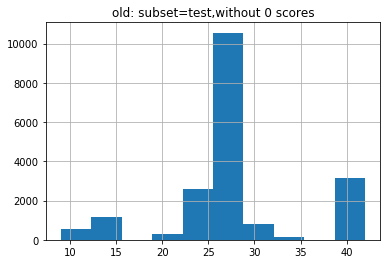

In [315]:
#plot histogram without the 0 values:
selection=(df_ward['Occupation Score_Word2Vec']!=0)
df_ward[selection]['Occupation Score_Word2Vec'].hist()
plt.title("old: subset=test,without 0 scores")

In [373]:
word2_score=list(df_ward['Occupation Score_Word2Vec'])
corex_score=list(df_ward['Occupation Score'])
def see_difference(word2_score,corex_score):
    difference=[]
    for i in range(len(word2_score)):
        if (word2_score[i]!=0 and corex_score[i]!=0):
            difference.append(abs(word2_score[i]-corex_score[i]))
    return sum(difference)/len(difference)

In [317]:
#merge Corex with Word2Vec
for i in range(len(corex_score)):
    if corex_score[i]==0:
        if word2_score[i]!=0:
            corex_score[i]=word2_score[i]
df_ward['Occupation Score Merged']=corex_score
df_ward

,DataID,RecordId,Name,HouseHoldId,Street Name,House Number,Dwelling Number,Family Number,Surname,Relationship,...,Attended School,Own or Rent,Home owned,Farm or House,Survivor of Confederate or Union of Army or Navy,Blind,Full Occupation,Occupation Score,Occupation Score_Word2Vec,Occupation Score Merged
0,31776_4449715-00931,18527185,Mamie Rodgers,18527185,Barrow St,51,4,24.0,Rodgers,Wife,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000
1,31776_4449715-00931,18527188,William K Micheals,18527188,Barrow St,49,5,25.0,Micheals,Head,...,NaN,Own,Mortgaged,House,NaN,NaN,Storage Worker Lawyer,26.62683,15.00000,26.62683
2,31776_4449715-00931,125203061,Elizabeth Micheals,18527188,Barrow St,49,5,25.0,Micheals,Wife,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000
3,31776_4449715-00931,125203062,Stewart Micheals,18527188,Barrow St,49,5,25.0,Micheals,Son,...,NaN,NaN,NaN,NaN,NaN,NaN,City Waiter Worker Water Inspector,29.60742,28.00000,29.60742
4,31776_4449715-00931,125203063,William Micheals Jr.,18527188,Barrow St,49,5,25.0,Micheals Jr.,Son,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64790,4449600_01218,106472699,James H Ritlaw,18553238,Little West 12 St,8,60.0,234.0,Ritlaw,Son,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000
64791,4449600_01218,106472700,Mary B Ritlaw,18553238,Little West 12 St,8,60.0,234.0,Ritlaw,Daughter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000
64792,4449600_01219,18553247,Ammar Mayne,18553247,St 14th St,452,61.0,235.0,Mayne,Head,...,NaN,Rent,NaN,House,NaN,NaN,NaN,0.00000,0.00000,0.00000
64793,4449600_01219,18553246,John J Dwyer,18553247,St 14th St,452,61.0,235.0,Dwyer,Boarder,...,NaN,NaN,NaN,NaN,NaN,NaN,Liquors Clerk,23.95357,0.00000,23.95357


Text(0.5, 1.0, 'old: subset=test,without 0 scores')

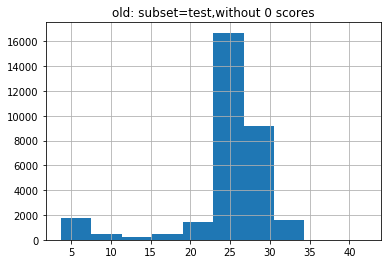

In [318]:
#plot histogram without the 0 values:
selection=(df_ward['Occupation Score Merged']!=0)
df_ward[selection]['Occupation Score Merged'].hist()
plt.title("old: subset=test,without 0 scores")

## Deal with Categories

In [333]:
import copy
occ_layer1=["manufacturing industries",
            "professional services",
            "trade & retail & business",
            "agriculture farmers",
            "government clerical officials",
            'domestic household',
            'transportation']

occ_sort=copy.deepcopy(document_total[len(documents_mod):])
occ_sort.sort()

In [334]:
occ_category={3:[range(11)],4:[range(11,23),range(287,304)],5:[range(23,60)],0:[range(60,249)],1:[range(249,287)],
              2:[range(304,384)],6:[range(384,436)]}
dic_occ={}# mapping occ to its bigger category in occ_layer1
for i in range(len(occ_sort)):
    for key,value in occ_category.items():
        for range_ in value:
            if i in range_:
                dic_occ[occ_sort[i]]=key

In [335]:
#try with word2vec
topic_category_word2vec={}
topic_category_helper_word2vec={i:[] for i in range(topic_num)}
for a,b in word2vec_result: # b is topic, a is occ index
    job_title=document_total[len(documents_mod):][a]
    job_category=dic_occ[job_title]
    topic_category_helper_word2vec[b].append(job_category)# without probability
for topic,lst in topic_category_helper_word2vec.items():
    if len(lst)!=0:
        total=len(lst)
        temp={}
        for a in range(len(occ_layer1)):
            temp[occ_layer1[a]]=lst.count(a)/total
        topic_category_word2vec[topic]=temp

In [338]:
#try with corex
topic_category_corex={}
topic_category_helper_corex={i:[] for i in range(topic_num)}
for job_num in pairs_proba.keys():
    topic_prob=pairs_proba[job_num]
    for pair in topic_prob:
        job_title=document_total[len(documents_mod):][job_num]
        job_category=dic_occ[job_title]
        weight = pair[1]
        topic_category_helper_corex[pair[0]].append((job_category,weight))

for topic in topic_category_helper_corex.keys():
    lst = topic_category_helper_corex[topic]
    if len(lst)!=0:
        total=0
        temp={}
        for a,b in lst: # a is category, b is proba
            total += b
        for i in range(len(occ_layer1)):
            count=0
            for a,b in lst:
                if i==a:
                    count+=b
            temp[occ_layer1[i]]=count/total
        topic_category_corex[topic]=temp

topic_category_corex           

{0: {'manufacturing industries': 0.9945945945945945,
  'professional services': 0.005405405405405395,
  'trade & retail & business': 0.0,
  'agriculture farmers': 0.0,
  'government clerical officials': 0.0,
  'domestic household': 0.0,
  'transportation': 0.0},
 1: {'manufacturing industries': 0.4999999999999999,
  'professional services': 0.0,
  'trade & retail & business': 0.0,
  'agriculture farmers': 0.0,
  'government clerical officials': 0.0,
  'domestic household': 0.0,
  'transportation': 0.4999999999999999},
 2: {'manufacturing industries': 0.10250655228273035,
  'professional services': 0.04986074709540387,
  'trade & retail & business': 0.0,
  'agriculture farmers': 0.0,
  'government clerical officials': 0.847632700621866,
  'domestic household': 0.0,
  'transportation': 0.0},
 3: {'manufacturing industries': 0.48406753083153453,
  'professional services': 0.0,
  'trade & retail & business': 4.939219847327916e-05,
  'agriculture farmers': 0.0,
  'government clerical offici

In [339]:
def word2vec_category(occ):
    if type(occ) == float:
        return 0
    temp=tokenize(occ)
    contentVector_list = []
    content_vector=get_contentVector(temp, word2vec_model)
    if type(content_vector)==np.float64:
        return 0
    contentVector_list.append(content_vector)
    X_predict = np.array(contentVector_list)
    result=logisticRegression_model.predict(X_predict)
    if result[0] in topic_category_word2vec.keys():
        category_proba=topic_category_word2vec[result[0]]
        sort_dict={k: v for k, v in sorted(category_proba.items(), key=lambda item: item[1],reverse=True)}
        category=list(sort_dict.keys())[0]
        return category
    else:
        return 0
df_ward['Occupation Category Word2Vec'] = df_ward['Full Occupation'].apply(lambda x : word2vec_category(x))

In [340]:
def corex_category(occ):
    if type(occ)!=float:
        vectorizer = CountVectorizer(stop_words='english', max_features=20000, vocabulary=fixed_vocabulary,binary=True)
        temp=[i.lower() for i in occ.split()]
        occ=" ".join(temp)
        doc_word1 = vectorizer.fit_transform([occ])
        doc_word1 = ss.csr_matrix(doc_word1)
        proba, mutual_info =anchored_topic_model.predict_proba(doc_word1)
        pairs=get_predict_proba(proba)
        if pairs == {}:
            return 0
        else:
            temp={i:0 for i in occ_layer1}
            #p=0
            for pair in pairs[0]:
                if pair[0] in topic_category_corex.keys():
                    proba_dict=topic_category_corex[pair[0]]
                    for a,b in proba_dict.items():
                        temp[a]+=pair[1]*b  
            sort_dict={k: v for k, v in sorted(temp.items(), key=lambda item: item[1],reverse=True)}
            category=list(sort_dict.keys())[0]
            return category
    else:
        return 0 
    
df_ward['Occupation Category Corex'] = df_ward['Full Occupation'].apply(lambda x : corex_category(x))

## Predict Second Layer

In [376]:
three_level=pd.read_excel('three_level_occupation_scores.xlsx')

In [390]:
small_category=list(set(list(three_level['Small Categories'])))
topic_num2=len(small_category)
topic_model2 = ct.Corex(n_hidden=topic_num2, words=words, eps=1e-2,max_iter=100, verbose=False, seed=1)
topic_model2.fit(doc_word[:len(documents_mod)], words=words)

In [391]:
topic_model2.tc 

5.612387407510058

In [394]:
anchor_words_new=[]
for cat in small_category:
    temp=tokenize(cat)
    anchor_words_new.append(temp)
    
anchored_topic_model_new, pairs2, pairs_proba2 =train_model(len(small_category),anchor_words_new)

------------ topic words ------------
0: street,laborers,road,garage,avenue,west,seventh,apartment,broker,dwelling
1: water,occupations,transportation,selected,boiling,cold,soak,slowly,soaked,privies
2: industries,food,laborers,iater,pttrablc,susos
3: officials,specified,proprietors,messengers,firm,lisa,raub,mona,der,inventories
4: stock,farm,laborers,dairy,packages,trading,indies,receipts,prices,shares
5: room,hall,dance,billiard,keepers,skating,rink,library,metz,cohn
6: foremen,place,walnut,overseers,finish,dark,floor,cork,half,handful
7: farm,garden,dairy,foremen,orchard,madison,brannan,farms,knees,charms
8: clerks,stores,subordinate,punching,twentyfirst,articled,punch,wid,originator,cressent
9: engineers,technical,jobs,blog,upload,metadata,video,software,audio,imagesabout
10: cement,finishers,inch,mold,cut,sides,inches,piece,ends,pieces
11: industries,steel,iron,laborers,works,cinder,large,niter,pyrite,wini
12: occupations,skilled,semi,engaged,status,occupational,sex,persons,classi

In [ ]:
def predict_small_category(occ):
    if type(occ)!=float:
        vectorizer = CountVectorizer(stop_words='english', max_features=20000, vocabulary=fixed_vocabulary,binary=True)
        temp=[i.lower() for i in occ.split()]
        occ=" ".join(temp)
        doc_word1 = vectorizer.fit_transform([occ])
        doc_word1 = ss.csr_matrix(doc_word1)
        result=anchored_topic_model_new.predict(doc_word1)
        pairs=get_predict_result(result)
        if pairs=={}:
            return 0
        else:
            category=[]
            for pair in pairs:
                category.append(small_category[pair[1]])
            return '/ '.join(category)
    else:
        return 0
    
df_ward['Occupation Small Category'] = df_ward['Full Occupation'].apply(lambda x : predict_small_category(x)) 

In [ ]:
df_ward['Occupation Small Category'] = df_ward['Full Occupation'].apply(lambda x : predict_small_category(x)) 

In [405]:
df_ward.to_csv('with_occ.csv')

In [408]:
print(len(df_ward[df_ward['Occupation Small Category']==0]))

32771


## You can run these functions with new dataset 

In [374]:
# input filename, make sure there are columns called Occupation and Industry 
def predict_occ(file):
    df_ward = pd.read_csv(file)
    df_ward['Occupation'] = df_ward['Occupation'].apply(lambda x : mod_occ(x))
    df_ward['Full Occupation'] = df_ward['Industry'] + ' ' + df_ward['Occupation']
    #use corex_model
    df_ward['Occupation Score Corex'] = df_ward['Full Occupation'].apply(lambda x : match_occ(x))
    df_ward['Occupation Score Corex'] =  df_ward['Occupation Score Corex'].apply(lambda x:  round(x, 5))
    #use word2vec_model 
    df_ward['Occupation Score Word2Vec'] = df_ward['Full Occupation'].apply(lambda x : word2vec_predict(x))
    df_ward['Occupation Score Word2Vec'] =  df_ward['Occupation Score Word2Vec'].apply(lambda x:  round(x, 5))
    #to see the average difference between these two results 
    word2_score=list(df_ward['Occupation Score Word2Vec'])
    corex_score=list(df_ward['Occupation Score Corex'])
    print(see_difference(word2_score,corex_score))
    #merge two results 
    for i in range(len(corex_score)):
        if corex_score[i]==0:
            if word2_score[i]!=0:
                corex_score[i]=word2_score[i]
    df_ward['Occupation Score Merged']=corex_score
    return df_ward

In [375]:
# input filename
def predict_big_job_category(file):
    df_ward = pd.read_csv(file)
    df_ward['Occupation'] = df_ward['Occupation'].apply(lambda x : mod_occ(x))
    df_ward['Full Occupation'] = df_ward['Industry'] + ' ' + df_ward['Occupation']
    df_ward['Occupation Category Word2Vec'] = df_ward['Full Occupation'].apply(lambda x : word2vec_category(x))
    df_ward['Occupation Category Corex'] = df_ward['Full Occupation'].apply(lambda x : corex_category(x))
    return df_ward 